In [1]:
import pandas as pd
import numpy
import numpy as np
from os.path import exists
from os import mkdir
from os import listdir
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib as mpl
import matplotlib
import matplotlib.pyplot as plt
#from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
import matplotlib.colors as cols
import matplotlib.gridspec as grid_spec
import scipy
import seaborn as sns
import re
import csv as csv
from itertools import cycle
from sklearn.neighbors import KernelDensity
import trimesh
import sys
from numpy.random import randn
from scipy import array, newaxis
from scipy.spatial import Delaunay
import proplot as pplt
import proplot as plot
from matplotlib.gridspec import GridSpec
from matplotlib.offsetbox import AnchoredText
import open3d as o3d
import os
import sys
import copy
import trimesh
import open3d as o3d
import scipy
from scipy import stats
from scipy.stats import mannwhitneyu, normaltest
from utils import *
# To illustrate examples
import numpy as np
from statannotations.Annotator import Annotator
from scipy import stats
from scipy.stats import mannwhitneyu, normaltest

#%env OPEN3D_CPU_RENDERING true

#install.packages("viridis")
#library(viridis)


mpl.rcParams["figure.dpi"] = 300
mpl.rcParams["legend.fontsize"] = 12
mpl.rcParams["font.size"] = 12

# import matplotlib.tri as mtri

# from scipy.interpolate import griddata

PLOTDIR = "plots"
DATADIR = "data"

DIRS = [PLOTDIR, DATADIR]

def plot_savepath(filename):
    return PLOTDIR + f"/{filename}"

def data_path(filename):
    return DATADIR + f"/{filename}"

for d in DIRS:
    if not exists(d):
        mkdir(d)
        
        
output_dir = f"figures/experiments/"
# Path(output_dir).mkdir(parents=True, exist_ok=True)


In [2]:
Organoid_Names = ['VOL_1857_1.xls',
                  'VOL_1857_2.xls', 
                  'VOL_1857_3.xls',
                  'AICS-31_CD34+_Vol_(2).xls',
                  'Day10CD34V.xls', 
                  'VOL_CD34_other.xls',]

organoid_pts = []

for name in Organoid_Names:
    df = pd.read_excel(data_path(name), header = None, skiprows =1)
    df = df.rename(columns = df.iloc[0]).drop(df.index[0])
    df_drop = df.drop(columns=['Unit', 'Category', 'Collection', 'Time', 'ID'])
    pts = df_drop.to_numpy()
    organoid_pts.append(pts)

In [3]:
Entity_Names = ['DOTS_1857_1.xls',
                'DOTS_1857_2.xls', 
                'DOTS_1857_3.xls',
                'AICS-31_CD34+_Dots_(2).xls',
                'Day10CD34D.xls',
                'DOTS_CD34_other.xls',]

entity_pts = []

for name in Entity_Names:
    df = pd.read_excel(data_path(name), header = None, skiprows =1)
    df = df.rename(columns = df.iloc[0]).drop(df.index[0])
    df_drop = df.drop(columns=['Unit', 'Category', 'Collection', 'Time', 'ID'])
    pts = df_drop.to_numpy()
    entity_pts.append(pts)

In [4]:
assert len(organoid_pts)==len(entity_pts)

distances = []

for index in range(len(organoid_pts)):
    # Organoids
    pcd_org = o3d.geometry.PointCloud()
    pcd_org.points = o3d.utility.Vector3dVector(organoid_pts[index])
    pcd_org.compute_convex_hull()
    pcd_org.estimate_normals()
    pcd_org.orient_normals_consistent_tangent_plane(10)
    
    with o3d.utility.VerbosityContextManager(
            o3d.utility.VerbosityLevel.Debug) as cm:
        mesh_org, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
            pcd_org, depth=10, scale=10, linear_fit=True)
    # print(mesh)
    mesh_org.paint_uniform_color([0.8, 0.2, 0])
    mesh_org.compute_vertex_normals()
    mesh_org.filter_smooth_simple(number_of_iterations=5)
    
    mesh_to_fill_org = o3d.t.geometry.TriangleMesh.from_legacy(mesh_org)
    mesh_to_fill_org.fill_holes(hole_size=10)
    final_mesh_org = mesh_to_fill_org.to_legacy()
    
    # Entities
    pcd_ent = o3d.geometry.PointCloud()
    pcd_ent.points = o3d.utility.Vector3dVector(entity_pts[index])
    pcd_ent.compute_convex_hull()
    pcd_ent.estimate_normals()
    pcd_ent.orient_normals_consistent_tangent_plane(10)
    
    with o3d.utility.VerbosityContextManager(
            o3d.utility.VerbosityLevel.Debug) as cm:
        mesh_ent, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
            pcd_ent, depth=10, scale=10, linear_fit=True)
    # print(mesh)
    mesh_ent.paint_uniform_color([0.8, 0.2, 0])
    mesh_ent.compute_vertex_normals()
    mesh_ent.filter_smooth_simple(number_of_iterations=5)
    
    mesh_to_fill_ent = o3d.t.geometry.TriangleMesh.from_legacy(mesh_ent)
    mesh_to_fill_ent.fill_holes(hole_size=10)
    final_mesh_ent = mesh_to_fill_ent.to_legacy()
    
    # Calculation of distances
    mesh_org_toleg = o3d.t.geometry.TriangleMesh.from_legacy(final_mesh_org)
    mesh_ent_toleg = o3d.t.geometry.TriangleMesh.from_legacy(final_mesh_ent)
    
    scene = o3d.t.geometry.RaycastingScene()
    mesh_ids = {}
    mesh_ids[scene.add_triangles(mesh_org_toleg)] = 'surface'
    mesh_ids[scene.add_triangles(mesh_ent_toleg)] = 'cells'

    query_point = np.asarray(entity_pts[index]).astype('float32')

    unsigned_distance = scene.compute_distance(query_point)
    distances.append(unsigned_distance.numpy())

[Open3D DEBUG] Input Points / Samples: 55481 / 26533
[Open3D DEBUG] #   Got kernel density: 0.00473022 (s), 491.336 (MB) / 491.336 (MB) / 491 (MB)
[Open3D DEBUG] #     Got normal field: 0.043534 (s), 492.957 (MB) / 492.957 (MB) / 492 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 5.663305e-07 / 3.142058e-02
[Open3D DEBUG] #       Finalized tree: 0.038254 (s), 496.949 (MB) / 496.949 (MB) / 496 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.112497 (s), 497.125 (MB) / 497.125 (MB) / 497 (MB)
[Open3D DEBUG] #Set point constraints: 0.04141 (s), 497.152 (MB) / 497.152 (MB) / 497 (MB)
[Open3D DEBUG] Leaf Nodes / Active Nodes / Ghost Nodes: 226934 / 257392 / 1961
[Open3D DEBUG] Memory Usage: 497.152 MB
[Open3D DEBUG] # Linear system solved: 1.66517 (s), 505.098 (MB) / 505.098 (MB) / 505 (MB)
[Open3D DEBUG] Got average: 0.0115709 (s), 505.395 (MB) / 505.395 (MB) / 505 (MB)
[Open3D DEBUG] Iso-Value: 5.126396e-01 = 2.844176e+04 / 5.548100e+04
[Open3D DEBUG] #          Total Solve:       3.6 (s

[Open3D DEBUG] Input Points / Samples: 45471 / 23219MB)	Nodes: 6112
                    GS: 5.4510e-02 -> 5.4510e-02 -> 4.4406e-04 (8.1e-03) [8]

[Open3D DEBUG] #   Got kernel density: 0.00427198 (s), 594.602 (MB) / 594.602 (MB) / 594 (MB)
[Open3D DEBUG] #     Got normal field: 0.0436099 (s), 594.602 (MB) / 594.602 (MB) / 594 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 7.074520e-07 / 3.216855e-02
[Open3D DEBUG] #       Finalized tree: 0.0340500 (s), 594.66 (MB) / 594.66 (MB) / 594 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.0709150 (s), 594.66 (MB) / 594.66 (MB) / 594 (MB)
[Open3D DEBUG] #Set point constraints: 0.00657916 (s), 594.66 (MB) / 594.66 (MB) / 594 (MB)
[Open3D DEBUG] Leaf Nodes / Active Nodes / Ghost Nodes: 220368 / 250368 / 1481
[Open3D DEBUG] Memory Usage: 594.660 MB
[Open3D DEBUG] # Linear system solved: 0.593023 (s), 597.449 (MB) / 597.449 (MB) / 597 (MB)
[Open3D DEBUG] Got average: 0.00806308 (s), 597.453 (MB) / 597.453 (MB) / 597 (MB)
[Open3D DEBUG] Iso-Value:

[Open3D DEBUG] #          Total Solve:       1.4 (s),     653.2 (MB)
[Open3D WARNING] Ignoring attribute 'normals' for TensorMap with primary key 'indices'
[Open3D DEBUG] Input Points / Samples: 12281 / 7767
[Open3D DEBUG] #   Got kernel density: 0.00217605 (s), 653.215 (MB) / 653.215 (MB) / 653 (MB)
[Open3D DEBUG] #     Got normal field: 0.0183361 (s), 653.215 (MB) / 653.215 (MB) / 653 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 1.245672e-06 / 1.529809e-02
[Open3D DEBUG] #       Finalized tree: 0.0260329 (s), 653.215 (MB) / 653.215 (MB) / 653 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.0426359 (s), 653.215 (MB) / 653.215 (MB) / 653 (MB)
[Open3D DEBUG] #Set point constraints: 0.011313 (s), 653.215 (MB) / 653.215 (MB) / 653 (MB)
[Open3D DEBUG] Leaf Nodes / Active Nodes / Ghost Nodes: 142983 / 160784 / 2625
[Open3D DEBUG] Memory Usage: 653.215 MB
Cycle[0] Depth[ 0/10]:	Updated constraints / Got system / Solved in:  0.000 /  0.000 /  0.000	(594.660 MB)	Nodes: 8
CG: 1.1380e-02 -> 

                  GS: 4.4709e-02 -> 4.4709e-02 -> 3.0984e-05 (6.9e-04) [8]
Cycle[0] Depth[10/10]:	Updated constraints / Got system / Solved in:  0.003 /  0.003 /  0.005	(637.328 MB)	Nodes: 256
                    GS: 6.7458e-03 -> 6.7458e-03 -> 3.3499e-07 (5.0e-05) [8]
Cycle[0] Depth[ 0/10]:	Updated constraints / Got system / Solved in:  0.000 /  0.000 /  0.000	(644.410 MB)	Nodes: 8
CG: 9.9003e-03 -> 9.9003e-03 -> 6.7184e-06 (6.8e-04) [32719]
Cycle[0] Depth[ 1/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.000 /  0.000	(644.410 MB)	Nodes: 27
  GS: 1.2263e-02 -> 1.2263e-02 -> 8.0005e-06 (6.5e-04) [8]
Cycle[0] Depth[ 2/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.001 /  0.001	(644.410 MB)	Nodes: 125
    GS: 2.5401e-02 -> 2.5401e-02 -> 3.4735e-05 (1.4e-03) [8]
Cycle[0] Depth[ 3/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.003 /  0.001	(644.410 MB)	Nodes: 729
      GS: 4.5162e-02 -> 4.5162e-02 -> 8.5926e-05 (1.9e-03) [8]
Cycle[0] Depth[ 4

In [5]:
dict_keys = ['A', 'B', 'C', 'D', 'E', 'F']

d = dict(zip(dict_keys, distances))

In [6]:
df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in d.items() ]))
df = df.melt(var_name = "Entity", value_name = "Distance to Surface (\u03BCm)")
df

Entity  Distance to Surface (μm)
0          A                  1.579277
1          A                  0.306275
2          A                  2.315311
3          A                 20.469770
4          A                  2.665250
...      ...                       ...
10741      F                       NaN
10742      F                       NaN
10743      F                       NaN
10744      F                       NaN
10745      F                       NaN

[10746 rows x 2 columns]

In [7]:
df.loc[df['Entity'] == 'A', 'Types'] = 'Repeat 1'  
df.loc[df['Entity'] == 'B', 'Types'] = 'Repeat 2'  
df.loc[df['Entity'] == 'C', 'Types'] = 'Repeat 3'  
df.loc[df['Entity'] == 'D', 'Types'] = 'Repeat 1'  
df.loc[df['Entity'] == 'E', 'Types'] = 'Repeat 2'  
df.loc[df['Entity'] == 'F', 'Types'] = 'Repeat 3'

#df_depth_analysis['Location'] = ['below-surface' if x >= 10 else 'near-surface' for x in df_depth_analysis["Distance to Surface (\u03BCm)"]]

In [8]:
df['Entity'] = df['Entity'].replace({'A':'1857',
              'B':'1857',
              'C':'1857',
              'D':'HSC',
              'E':'HSC',
              'F':'HSC'}) 

In [9]:
df[np.isfinite(df["Distance to Surface (\u03BCm)"])]
df_final = df[df["Distance to Surface (\u03BCm)"] > 0.0001]

In [10]:
df_final

Entity  Distance to Surface (μm)     Types
0      1857                  1.579277  Repeat 1
1      1857                  0.306275  Repeat 1
2      1857                  2.315311  Repeat 1
3      1857                 20.469770  Repeat 1
4      1857                  2.665250  Repeat 1
...     ...                       ...       ...
9077    HSC                156.765045  Repeat 3
9078    HSC                167.463226  Repeat 3
9079    HSC                227.550812  Repeat 3
9080    HSC                153.320679  Repeat 3
9081    HSC                155.166489  Repeat 3

[4373 rows x 3 columns]

In [11]:
#leukemia data
df.rename(columns={'A': 'Leukemia Replicate 1',
                            'B': 'Leukemia Replicate 2',
                            'C': 'Leukemia Replicate 3',
                            'D': 'Healthy Replicate 1',
                            'E': 'Healthy Replicate 2',
                            'F': 'Healthy Replicate 3'}, inplace=True)

df.to_excel("unmelted_leukemia_data.xlsx", sheet_name='unmeltedLEUK') 
df_leukemia = df.melt(var_name = "Entity", value_name = "Distance to Surface (\u03BCm)")
df_leukemia.to_excel("melted_leukemia_data.xlsx", sheet_name='meltedLEUK') 
#df_leukemia['Location'] = ['below-surface' if x >= 10 else 'near-surface' for x in df_leukemia["Distance to Surface (\u03BCm)"]]

/var/folders/9w/4xkqf_xd0kg5ycr900ldx_9w0000gn/T/ipykernel_11777/1501090554.py:10: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  df_leukemia = df.melt(var_name = "Entity", value_name = "Distance to Surface (\u03BCm)")


In [16]:
sns.set_theme(style="ticks", palette="pastel")
fig, axes = plt.subplots(1, 2, figsize=(25, 10), gridspec_kw={'width_ratios': [1, 2]})
g = sns.stripplot(ax=axes[0], data=df_final,
              x="Entity", y="Distance to Surface (\u03BCm)",
              hue="Types", palette="GnBu", linewidth=0.5,
              size=5, alpha=0.6, jitter=.30, dodge=True,
                 )
    
g.set_yscale("log")
# the non-logarithmic labels you want
ticks = [0.01, 0.1, 1, 10, 100, 1000]
g.set_yticks(ticks)
g.set_yticklabels(ticks)

g.tick_params(axis='x', rotation=45)
g.xaxis.label.set_visible(False)

sns.move_legend(
    g, loc="best", ncol=1, frameon=False, columnspacing=5, handletextpad=0
)

g.axhline(10, color='r')

g = sns.histplot(
    df_final,
    x="Distance to Surface (\u03BCm)", hue="Entity",
    bins=200,
    multiple="stack",
    palette="GnBu",
    element="bars",
    edgecolor=".3",
    common_norm=False,
    kde=False,
    pmax=1000,
    linewidth=.2,
    stat="count",
    log_scale=True,
)

sns.move_legend(
    g, loc="best", ncol=1, frameon=False, columnspacing=5, handletextpad=0)

# the non-logarithmic labels you want
axes[0].grid(color='black', alpha=0.5, linestyle='dashed', linewidth=0.5)
axes[0].set_xlabel('Entity', fontweight ='bold')
axes[0].set_ylabel('Distance to Surface (\u03BCm)', fontweight ='bold')
ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
g.set_yticks(ticks)
g.set_yticklabels(ticks)

axes[1].grid(color='black', alpha=0.5, linestyle='dashed', linewidth=0.5)
axes[1].set_xlabel('Distance to Surface (\u03BCm)', fontweight ='bold')
axes[1].set_ylabel('Count', fontweight ='bold')
ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
g.set_yticks(ticks)
g.set_yticklabels(ticks)

g.axvline(x=10, color='r')

#axes[1].set_title("Violinplot", fontsize=20)

#g = ax=axes[2].imshow(img_org)
#axes[2].set_xlabel('Position X (\u03BCm)', fontweight ='bold')
#axes[2].set_ylabel('Position Y (\u03BCm)', fontweight ='bold')

#g = ax=axes[3].imshow(img_ent)
#axes[3].set_xlabel('Position X (\u03BCm)', fontweight ='bold')
#axes[3].set_ylabel('Position Y (\u03BCm)', fontweight ='bold')


texts = ['H', 'I']
ax = fig.get_axes()
for a,l in zip(ax, texts):
    a.annotate(l, xy=(-0.1, 1.1), xycoords="axes fraction", fontsize=35, weight = 'bold')
#plt.suptitle('Label_Distance Consistent', fontsize = 20)
plt.savefig(plot_savepath('Seaborn_1857_v Healthy.pdf'), bbox_inches='tight')
plt.savefig(plot_savepath('Seaborn_1857_v Healthy.png'), dpi=300, bbox_inches='tight')

In [13]:
#vis = o3d.visualization.Visualizer()
#vis.create_window(visible=False) #works for me with False, on some systems needs to be true
#vis.add_geometry(final_mesh_org)
#vis.update_geometry(final_mesh_org)
#vis.poll_events()
#vis.update_renderer()
#vis.capture_screen_image(plot_savepath('1857.png'), do_render=True)
#vis.destroy_window()

In [14]:
df_export = df[df["Distance to Surface (\u03BCm)"] > 50]
df_export.to_excel("leukvhealthy.xlsx", sheet_name='meltedLEUK') 

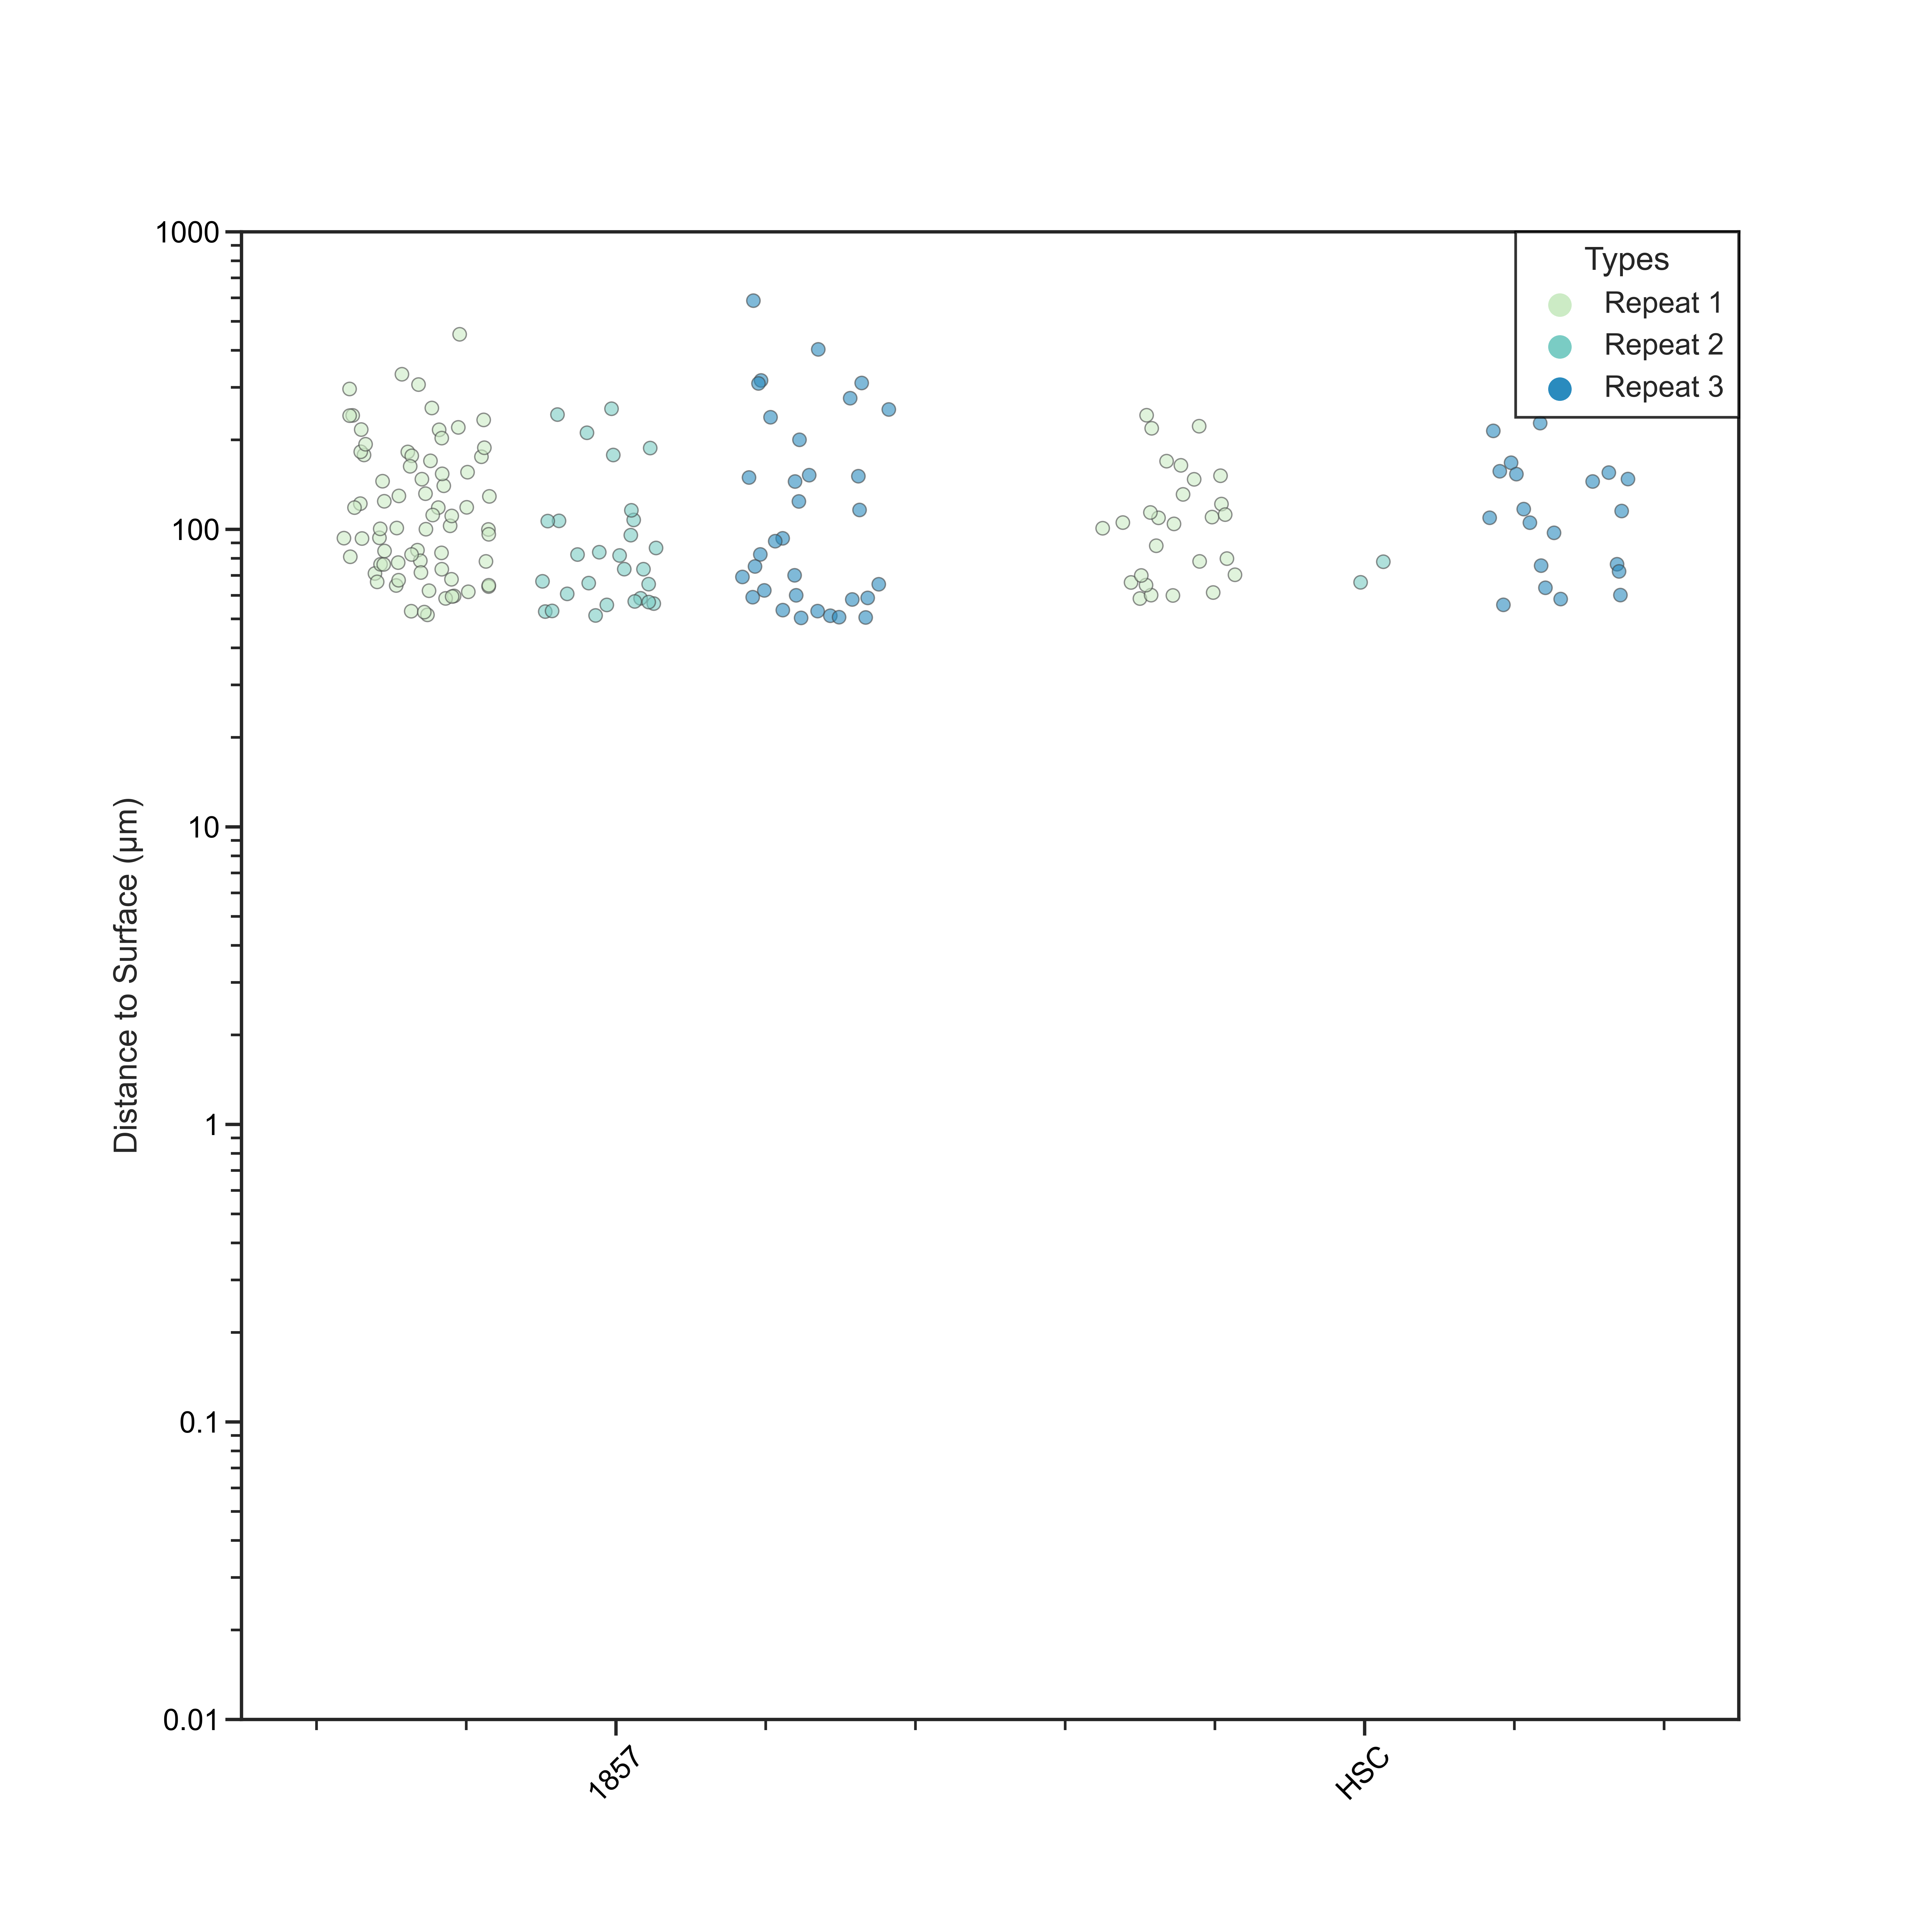

In [15]:
sns.set_theme(style="ticks", palette="pastel")
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
g = sns.stripplot(data=df_export,
              x="Entity", y="Distance to Surface (\u03BCm)",
              hue="Types", palette="GnBu", linewidth=0.5,
              size=5, alpha=0.6, jitter=.30, dodge=True,
                 )
    
g.set_yscale("log")
# the non-logarithmic labels you want
ticks = [0.01, 0.1, 1, 10, 100, 1000]
g.set_yticks(ticks)
g.set_yticklabels(ticks)

g.tick_params(axis='x', rotation=45)
g.xaxis.label.set_visible(False)